In [1]:
## Chapter 10 Classification
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [4]:
url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [6]:
def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

In [7]:
ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Logistic regression

In [9]:
from sklearn.linear_model import (
    LogisticRegression,
)
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8015267175572519

In [10]:
lr.predict(X.iloc[[0]])

array([0], dtype=int64)

In [11]:
lr.predict_proba(X.iloc[[0]])

array([[0.89709139, 0.10290861]])

In [12]:
lr.predict_log_proba(X.iloc[[0]])

array([[-0.10859754, -2.27391397]])

In [13]:
lr.decision_function(X.iloc[[0]])

array([-2.16531643])

In [14]:
lr.intercept_

array([1.22466932])

In [15]:
# baseline for survival
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
inv_logit(lr.intercept_)

array([0.77288422])

In [18]:
cols = X.columns
for col, val in sorted(
    zip(cols, lr.coef_[0]),
    key=lambda x: x[1],
    reverse=True,
):
    print(
        col, ' ', val
    )

fare   0.10413724799213424
parch   -0.06316097205205971
sibsp   -0.2728563996808178
age   -0.29467884654790605
embarked_Q   -0.49548594178075817
embarked_S   -0.5083352187788127
pclass   -0.7382834065450177
sex_male   -2.408396486376467


## Naive bayes

In [19]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.7557251908396947

In [20]:
nb.predict(X.iloc[[0]])

array([0], dtype=int64)

## Supporting vector machine

In [21]:
from sklearn.svm import SVC
svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.806615776081425

In [22]:
svc.predict(X.iloc[[0]])

array([0], dtype=int64)

## Nearest Neighbors

In [23]:
from sklearn.neighbors import (
    KNeighborsClassifier,
)
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc.score(X_test, y_test)

0.7684478371501272

In [24]:
knc.predict(X.iloc[[0]])

array([0], dtype=int64)

# Decision Trees

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.8142493638676844

In [26]:
dt.predict(X.iloc[[0]])

array([0], dtype=int64)

In [32]:
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(col, ' ', val)

sex_male   0.6068898192868756
pclass   0.24750773215172353
sibsp   0.052142572256820424
fare   0.050182180863472654
age   0.0432776954411079


## Random Forest

In [33]:
from sklearn.ensemble import (
    RandomForestClassifier,
)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7659033078880407

In [34]:
rf.predict(X.iloc[[0]])

array([0], dtype=int64)

In [35]:
for col, val in sorted(
    zip(X.columns, rf.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(col, ' ', val)

age   0.2804249890166937
fare   0.2741984551300236
sex_male   0.2297780987888693
pclass   0.08569104240719874
sibsp   0.052911078177495796


## Xgboost

In [37]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(random_state=42)
xgb_class.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
)
xgb_class.score(X_test, y_test)

[0]	validation_0-error:0.188295
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.188295
[2]	validation_0-error:0.188295
[3]	validation_0-error:0.188295
[4]	validation_0-error:0.188295
[5]	validation_0-error:0.188295
[6]	validation_0-error:0.203562
[7]	validation_0-error:0.203562
[8]	validation_0-error:0.203562
[9]	validation_0-error:0.203562
[10]	validation_0-error:0.203562
Stopping. Best iteration:
[0]	validation_0-error:0.188295



0.811704834605598

In [38]:
xgb_class.predict(X.iloc[[0]])

array([0], dtype=int64)

In [39]:
for col, val in sorted(
    zip(
        X.columns,
        xgb_class.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(col, ' ', val)

sex_male   0.66483134
pclass   0.15527084
sibsp   0.06909824
embarked_S   0.042461522
age   0.038223404


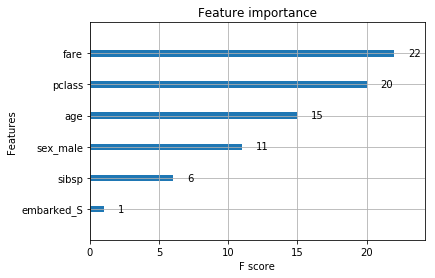

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgb_class, ax=ax)
#fig.savefig("images/mlpr_1005.png", dpi=300)

In [42]:
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[sex_male<1] yes=1,no=2,missing=1
	1:[pclass<0.23096557] yes=3,no=4,missing=3
		3:leaf=0.169411764
		4:[fare<-0.203882411] yes=7,no=8,missing=7
			7:leaf=0.00751879672
			8:leaf=-0.139393941
	2:[age<-1.49289274] yes=5,no=6,missing=5
		5:[sibsp<1.35050142] yes=9,no=10,missing=9
			9:leaf=0.123809531
			10:leaf=-0.129411772
		6:[pclass<-0.957598865] yes=11,no=12,missing=11
			11:leaf=-0.0761904791
			12:leaf=-0.150450453



In [43]:
# score from first tree leaf 7
1 / (1 + np.exp(-1 * 0.1238))

0.5309105310475829

## Light GBM

In [45]:
import lightgbm as lgb
lgbm_class = lgb.LGBMClassifier(
    random_state=42
)
lgbm_class.fit(X_train, y_train)
lgbm_class.score(X_test, y_test)

0.806615776081425

In [46]:
lgbm_class.predict(X.iloc[[0]])

array([0], dtype=int64)

In [47]:
for col, val in sorted(
    zip(cols, lgbm_class.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(col, ' ', val)

fare   1285
age   1198
sex_male   113
pclass   112
sibsp   99


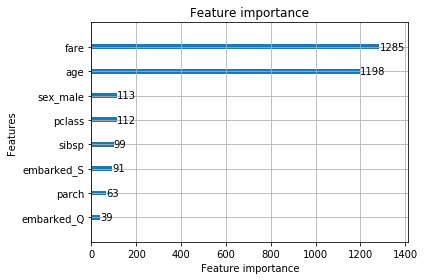

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_importance(lgbm_class, ax=ax)
fig.tight_layout()
#fig.savefig("images/mlpr_1008.png", dpi=300)